<a href="https://colab.research.google.com/github/hanyoseob/lecture_optimization/blob/main/chapter11_Conjugate_gradient_method_for_super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)
---
>In mathematics, ___the conjugate gradient method___ is an algorithm for the numerical solution of particular systems of linear equations, namely those whose matrix is [positive-definite](https://en.wikipedia.org/wiki/Definite_matrix#Negative-definite.2C_semidefinite_and_indefinite_matrices). The conjugate gradient method is often implemented as an iterative algorithm, applicable to sparse systems that are too large to be handled by a direct implementation or other direct methods such as the Cholesky decomposition. Large sparse systems often arise when numerically solving partial differential equations or optimization problems.
>
>![conjugate gradient method](https://upload.wikimedia.org/wikipedia/commons/b/bf/Conjugate_gradient_illustration.svg "")
>
>__[FIGURE] A comparison of the convergence of [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) with optimal step size (in green) and [conjugate vector](https://en.wikipedia.org/wiki/Conjugate_gradient_method) (in red) for minimizing a quadratic function associated with a given linear system. Conjugate gradient, assuming exact arithmetic, converges in at most n steps, where n is the size of the matrix of the system (here n = 2).__
>
>__Before following an implementation below, PLEASE REVIEW [MATHMETICAL DSCRIPTION](https://en.wikipedia.org/wiki/Conjugate_gradient_method) since the more details are described [HERE](https://en.wikipedia.org/wiki/Conjugate_gradient_method).__

---
In this chapter, we will cover a ___deblurring problem___ (called ___image enhancement___). Specifically, we will implement a ___deblurring method___ using [conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) from the Gaussian-blurred image.

To apply __the conjugate gradient method__ for solving linear equations, the system matrix $A$ must be __symmetric positive-definite__. Easy way to satisfy the symmetric positive-definite is that the matrix $A$ is composed as a product $A = B^TB$.

When we address the optimization problem $F(x)$ defined as:
> $F(x) = \frac{1}{2} || Ax - y ||_2^2$,

its derivative $\nabla F(x)$ is represented by:
> $\nabla F(x) = A^T(Ax - y)$.

The optimal solution $x^*$ is defined when the derivative $\nabla F(x)$ equals to zeros like:
> $\nabla F(x) = A^T(Ax - y)$
>
> $~~~~~~~~~~~= 0$.

Therefore, above equation can be reformulated as:
> $A^TAx = A^Ty$.

Since $A^TA$ is __symmetric positive-definite matrix__, the optimization problem can be solved using the [conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method).


## Description of the problem addressed by conjugate gradients
---
Suppose we want to solve the system of linear equations
> $Ax=b$,

for the vector $x$, where the known $n \times n$ matrix $A$ is symmetric (i.e., $A^T = A$), positive-definite (i.e., $x^TAx > 0$ for all non-zero vectors $x \in \mathbb{R}^n$), and real, and $b$ is known as well. We denote the unique solution of this system by $x^*$.

## General solution
---
> $r_0 := b - Ax_0$
>
> if $r_0$ is sufficiently small, then return $x_0$ as the result
>
> $p_0 := r_0$
> 
> k := 0
> 
> repeat
>
>> $a_k := \frac{r_k^Tr_k}{p_k^TAp_k}$
>> 
>> $x_{k+1} := x_k + \alpha_kp_k$
>>
>> $r_{k+1} := r_k - \alpha_kAp_k$
>>
>> if $r_{k+1}$ is sufficiently small, then exit loop
>>
>> $\beta_k := \frac{r_{k+1}^Tr_{k+1}}{r_k^Tr_k}$
>>
>> $p_{k+1} := r_{k+1} + \beta_k p_k$
>>
>> k := k + 1
>
> end repeat
>
> return $x_{k+1}$ as the result

___THIS IS THE MOST COMMONLY USED ALGORITHM.___


# Implementation
---

1. Problem definition
2. Implement the gradient descent method

## Step 1. Problem definition

1. Objective function $F(x)$
> $F(x) = \frac{1}{2} || Ax - y ||_2^2$.

2. Its derivative $\nabla F(x)$ 
> $\nabla F(x) = A^T(Ax - y)$.
>
>> The optimal solution $x^*$ when the derivative $\nabla F(x)$ equals to zeros like:
>>
>> $\nabla F(x) = A^T(Ax - y)$
>>
>> $~~~~~~~~~~~= A^TAx - A^Ty$
>>
>> $~~~~~~~~~~~= 0$.

3. Linear equation
> $A^TAx = A^Ty$,
>
>> To formulate the equation form of the conjugate gradient method, 
>>
>> we reformulated above equation as shown below:
>>
>> $\bar{A}x = \bar{b}$,
>>
>> where $\bar{A} = A^TA$ and $\bar{b} = A^Ty$ .


### Step 2. Conjugate gradient method

1. Add packages
2. Define 2D [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function)
3. Set the system matrix $A$ and its transpose $A^T$
4. Set the parameters of the conjugate gradient method
5. Run the conjugate gradient method

### Add packages

In [ ]:
# Mathmetical packages
import numpy as np
from scipy.signal import convolve

# Image processing package
from skimage import data
from skimage.transform import resize

# Metrics calculating packages
from skimage.metrics import normalized_root_mse as compare_nmse
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# Ploting packages
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

# Ploting options
font = {'family': 'normal',
        'weight': 'bold',
        'size': 10}

matplotlib.rc('font', **font)


### Define [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function)

> $f(x, y) = A \exp \left( -{\left( {\frac{(x - x_0)^2}{2\sigma_X^2}} + {\frac{(y - y_0)^2}{2\sigma_Y^2}} \right)} \right),$

where $A$ is the amplitude, $x_0$ and $y_0$ are the center positions, $\sigma_X$ and $\sigma_Y$ are the standard deviations.

In [ ]:
def gaus2d(nx, ny, x0=0, y0=0, sgmx=3, sgmy=3, A=1):

    x = np.linspace(-nx/2, nx/2, nx)
    y = np.linspace(-ny/2, ny/2, ny)
    x, y = np.meshgrid(x, y)

    ker = A * np.exp(-(0.5*((x - x0)/sgmx)**2 + 0.5*((y - y0)/sgmy)**2))
    ker = ker / np.sum(ker)

    return ker


### Set the system matrix $A$ and its transpose $A^T$

__If you are not familiar with the concept of the transpose, please check out [my lecture video related to transpose](https://www.youtube.com/watch?v=erdPhFEoFYc) and [wikipedia](https://en.wikipedia.org/wiki/Transpose).__ 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


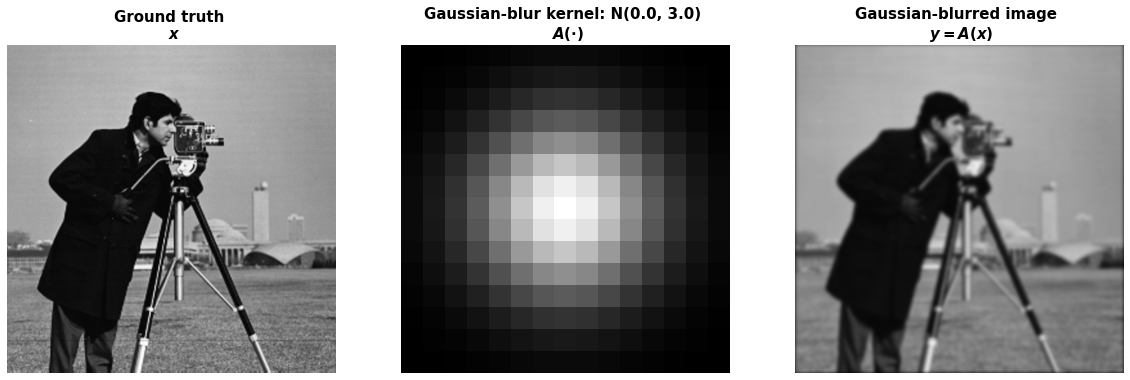

Result from Gaussian-blurred
NSME: 1.1977e-01
PSNR: 24.0498
SSIM: 0.8574
 


In [ ]:
# Load the clean image x ( = ground truth ) 
N = 512   # number of rows for the image
M = 512   # number of colums for the image

x_gt = data.camera().astype(dtype=np.float64)/255.0
x_gt = resize(x_gt, output_shape=(N, M))

# Generate Gaussian kernel A
K = 15    # size of the Gaussian kernel (*the size of kernel must be matched with 'ODD NUMBER'.)
MEAN = 0  # mean of Gaussian kernel
SGM = 3   # standard deviation of Gaussian kernel

ker = gaus2d(K, K, x0=MEAN, y0=MEAN, sgmx=SGM, sgmy=SGM)

# Define the System operator (A) and its transpose (AT)
# A: Convolution operation with Gaussian kernel
# AT: Convolution operation with fliped Gaussian kernel
A = lambda x: convolve(x, ker, mode='same')
AT = lambda y: convolve(y, np.flip(np.flip(ker, axis=0), axis=1), mode='same')

# Generate the output y from the system operator A
y = A(x_gt)


# Plot the images
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 8))

axs[0].imshow(x_gt, vmin=0, vmax=1, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Ground truth \n $x$', fontsize=15, fontweight='bold')

axs[1].imshow(ker, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Gaussian-blur kernel: N(%.1f, %.1f) \n $A( \cdot )$' % (MEAN, SGM), fontsize=15, fontweight='bold')

axs[2].imshow(y, vmin=0, vmax=1, cmap='gray')
axs[2].axis('off')
axs[2].set_title('Gaussian-blurred image \n $y = A(x)$', fontsize=15, fontweight='bold')

plt.show()

# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
x_gaus = y

nmse_gaus = compare_nmse(x_gt, x_gaus)
psnr_gaus = compare_psnr(x_gt, x_gaus)
ssim_gaus = compare_ssim(x_gt, x_gaus)

print('Result from Gaussian-blurred')
print('NSME: %.4e' % nmse_gaus)
print('PSNR: %.4f' % psnr_gaus)
print('SSIM: %.4f' % ssim_gaus)
print(' ')

### Set the parameters of the conjugate gradient method

In [ ]:
# F: Objective function
F = lambda x: 1/2 * np.sum( (A(x) - y) ** 2 )

# A_cg: The system matrix to apply the conjugate gradient method
# b: Its measurement (CONSTANT VALUES)
A_cg = lambda x: AT( A(x) )
b = AT(y)

# Hyper parameters for the conjugate gradient descent method
max_iter = 300


#### Run the conjugate graident method

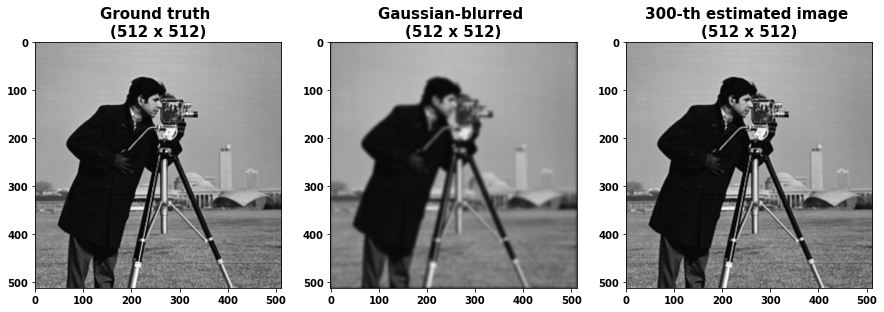

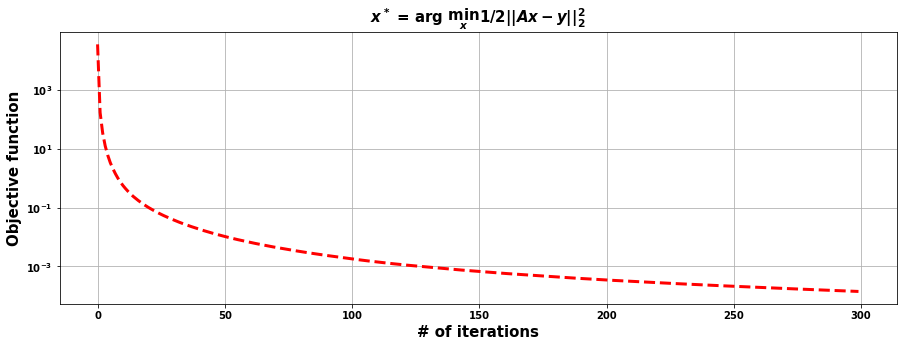

Result from conjugate gradient method
NSME: 3.2555e-02
PSNR: 35.3642
SSIM: 0.9796


In [ ]:
x = np.zeros((N, M))

x_iter = []
y_iter = []

x_iter.append(x)
y_iter.append(F(x))

# Search the solution using the conjugate gradient method
# r = b - np.matmul(A, x)
r = b - A_cg(x)
p = r
# rs_old = np.matmul(r.T, r)
rs_old = np.matmul(r.reshape(1, -1), r.reshape(-1, 1))

for i in range(1, max_iter + 1):
  # Ap = np.matmul(A, p)
  Ap = A_cg(p)

  # alpha = rs_old / np.matmul(p.T, Ap)
  alpha = rs_old / (np.matmul(p.reshape(1, -1), Ap.reshape(-1, 1)))
  
  x = x + alpha * p
  r = r - alpha * Ap

  # rs_new = np.matmul(r.T, r)
  rs_new = np.matmul(r.reshape(1, -1), r.reshape(-1, 1))

  if np.sqrt(rs_new) < 1e-10:
    x_iter.append(x)
    y_iter.append(F(x))
    break

  p = r + (rs_new / rs_old) * p
  rs_old = rs_new

  x_iter.append(x)
  y_iter.append(F(x))

  # Plot the results from gradient descent method
  if ((i + 1) % 10) == 0 or (i + 1) == max_iter:
    # Plot the images from ground truth, gradient descent method, and difference map.
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

    ax = axs[0]
    pcm = ax.imshow(x_gt, cmap='gray', vmin=0, vmax=1)
    ax.set_title('Ground truth \n(%d x %d)' % (N, M), fontsize=15, fontweight='bold')
    # fig.colorbar(pcm, ax=ax)

    ax = axs[1]
    pcm = ax.imshow(y, cmap='gray', vmin=0, vmax=1)
    ax.set_title('Gaussian-blurred \n(%d x %d)' % (N, M), fontsize=15, fontweight='bold')
    # fig.colorbar(pcm, ax=ax)

    ax = axs[2]
    pcm = ax.imshow(x, cmap='gray', vmin=0, vmax=1)
    ax.set_title('%d-th estimated image \n(%d x %d)' % (i + 1, N, M), fontsize=15, fontweight='bold')
    # fig.colorbar(pcm, ax=ax)

    # Plot a curve of the objective function
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(15, 5))

    axs.semilogy(y_iter, 'r--', linewidth=3)
    axs.grid(True)
    axs.set_xlabel('# of iterations', fontsize=15, fontweight='bold')
    axs.set_ylabel('Objective function', fontsize=15, fontweight='bold')
    axs.set_title('$x^*$ = arg $\min_x 1/2 || Ax - y ||^2_2$', fontsize=15, fontweight='bold')

    display.clear_output(wait=True)
    plt.show()

# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
x_est_cg = x

nmse_cg = compare_nmse(x_gt, x_est_cg)
psnr_cg = compare_psnr(x_gt, x_est_cg)
ssim_cg = compare_ssim(x_gt, x_est_cg)

print('Result from conjugate gradient method')
print('NSME: %.4e' % nmse_cg)
print('PSNR: %.4f' % psnr_cg)
print('SSIM: %.4f' % ssim_cg)

# Conclusion

In this chapter, we covered ___the deblurring problem___, which is the ___realistic___ and ___practical___ problems in a natural image processing. Below figure shows the results from [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function) and [the conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method). [The conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) provides an high-enhanced image quality and its quantitative metrics are significantly improved than other methods like [a gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent) and [a newton's method](https://en.wikipedia.org/wiki/Newton%27s_method).

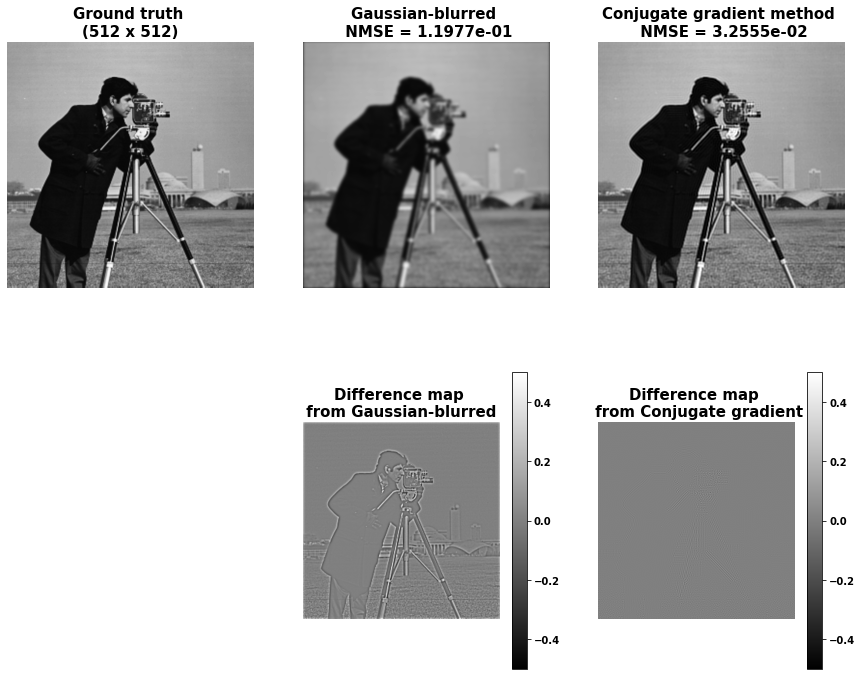

 
Quantitative metrics
 
Normalized Mean Sqaure Error (NMSE)
Gaussian-blurred image   : 1.1977e-01
Conjugate gradient method: 3.2555e-02
 
Peak Signal to Noise Ratio (PSNR)
Gaussian-blurred image   : 24.0498
Conjugate gradient method: 35.3642
 
Structural Similarity Index Measure (SSIM)
Gaussian-blurred image   : 0.8574
Conjugate gradient method: 0.9796
 


In [ ]:
# Plot the results
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 12))

ax = axs[0, 0]
pcm = ax.imshow(x_gt, cmap='gray', vmin=0, vmax=1)
ax.set_title('Ground truth \n(%d x %d)' % (N, M), fontsize=15, fontweight='bold')
ax.axis('off')
# fig.colorbar(pcm, ax=ax)

ax = axs[0, 1]
pcm = ax.imshow(x_gaus, cmap='gray', vmin=0, vmax=1)
ax.set_title('Gaussian-blurred \n NMSE = %.4e' % (nmse_gaus), fontsize=15, fontweight='bold')
ax.axis('off')
# fig.colorbar(pcm, ax=ax)

ax = axs[0, 2]
pcm = ax.imshow(x_est_cg, cmap='gray', vmin=0, vmax=1)
ax.set_title('Conjugate gradient method \n NMSE = %.4e' % (nmse_cg), fontsize=15, fontweight='bold')
ax.axis('off')
# fig.colorbar(pcm, ax=ax)

ax = axs[1, 0]
ax.axis('off')

ax = axs[1, 1]
pcm = ax.imshow(x_gt - x_gaus, cmap='gray', vmin=-0.5, vmax=+0.5)
ax.set_title('Difference map \n from Gaussian-blurred ', fontsize=15, fontweight='bold')
ax.axis('off')
fig.colorbar(pcm, ax=ax)

ax = axs[1, 2]
pcm = ax.imshow(x_gt - x_est_cg, cmap='gray', vmin=-0.5, vmax=+0.5)
ax.set_title('Difference map \n from Conjugate gradient', fontsize=15, fontweight='bold')
ax.axis('off')
fig.colorbar(pcm, ax=ax)

plt.show()

# Print the quantitative metrics
print(' ')
print('Quantitative metrics')
print(' ')

print('Normalized Mean Sqaure Error (NMSE)')
print('Gaussian-blurred image   : %.4e' % nmse_gaus)
print('Conjugate gradient method: %.4e' % nmse_cg)
print(' ')

print('Peak Signal to Noise Ratio (PSNR)')
print('Gaussian-blurred image   : %.4f' % psnr_gaus)
print('Conjugate gradient method: %.4f' % psnr_cg)
print(' ')

print('Structural Similarity Index Measure (SSIM)')
print('Gaussian-blurred image   : %.4f' % ssim_gaus)
print('Conjugate gradient method: %.4f' % ssim_cg)
print(' ')

#References
---

1. [Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)
2. [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function)


# Next
---

Next chapter, we will implement the [conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) to cover a medical image processing based computed tomography (CT).